# Survival Analysis

This is the start of a tutorial on what survival analysis is and how we can use it to help work with HI data which includes both detections and non-detections (aka upper limits).

Heavily based on: David Stark's survival analysis code (https://github.com/dvstark/survival/tree/main, which was used in Stark et al. 2021.

Also uses the lifelines package in python.

This is a work in progress - I had a lot of trouble getting the R packages to play nicely with my installation of python, so this isn't complete yet.


## What is Survival Analysis?

Survival analysis describes statistical techniques which are designed to deal with incomplete data. It was initially developed for statistics of time to patient death in medical settings (e.g. to estimate likely life expectancy following a disease). This technique allows an estimate in instances where some fraction of patients survived (yes it's a slightly gruesome name once you know that).

Most online tutorials use time series data - statistics of when events happen, including times to events which haven't yet happened.

e.g. https://datatab.net/tutorial/survival-analysis

However this technique can be applied to any data set which is a mixture of measurements and upper limits on that measurement - in our case the data we have is HI detections and upper limits (from non-detections).

The [Survival Analysis Wikipedia](https://en.wikipedia.org/wiki/Survival_analysis) article has more details on the history of the technique, and names used in applications in other fields, such as engineering (reliability analysis) or economics (duration analysis).


### Basic Example

Let's start with a basic example using some made up data.

**IMPORTANT** You will need to put the code `survival.py` from  David Stark's survival analysis code respository (https://github.com/dvstark/survival/tree/main) into the directory you are running this code from.

In [1]:
##GOOGLE COLLAB SPECIFIC
#This lets the Notebook see Google Drive files. Need only run once.
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
#Import statements

#import os
#os.chdir('/Users/dstark/python_packages/my_packages/survival/')
#print(os.getcwd())
#You need the above three lines if you put the survival.py anywhere but in the directory you are running this Notebook from
#And you will need to edit it to tell this notebook where it can find survival.py on your computer
#(or the server you are running this notebook on)


##GOOGLE COLLAB SPECIFIC
#This is to tell the Notebook where survival.py is located. If this popss up an error
#make sure you imported "drive" above
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/SurvivalAnalysis')

#You may also need rpy2 module to be imported.
#Try uncommenting:
#!pip install rpy2

#And/or !pip install fortranformat to run Dave's Survival.py code
!pip install fortranformat



In [ ]:
#Might need to do this one too for lifelines
!pip install lifelines

In [3]:
from survival import setup, ats_fit, kaplan_meier

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal, choice

In [5]:
#Run Dave Stark's setup script (sets up R and stuff)
setup()

(as ‘lib’ is unspecified)







	‘/tmp/RtmpPUgFyS/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpPUgFyS/downloaded_packages’

(as ‘lib’ is unspecified)



In [89]:
#let's make some fake data
x = np.random.uniform(size=100) #Make a unfiform random distrobution of 100 x values from 0-1
y = 5 + (3 * x) + np.random.uniform(size=100) #Just a line with error of size 0-1

# set ~30% to be upper limits in y
lims = np.zeros(len(x)).astype(bool) #Sets up a logic array of all "FALSE" entries
lims[np.random.choice(np.arange(len(lims)), size=int(0.3*len(lims)))] = True #Randomly sets 30% of them to be TRUE

#Make the upper limits just a bit smaller than the measurements
y[lims]=y[lims]-0.2

#Fit a straight line to the measurements
a=np.polyfit(x[~lims],y[~lims],1)

#Make line to plot
p = np.poly1d(a)
xplot=np.linspace(0, 1, 10)
yplot=p(xplot)

#Calculate residuals from line plot
yres = y-p(x)

Text(0.5, 0, 'yresidual')

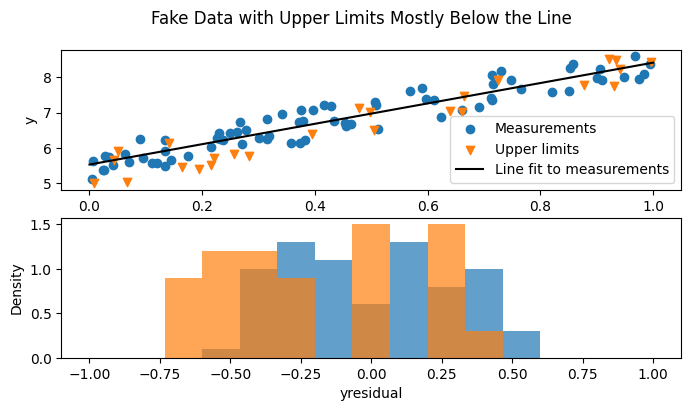

In [79]:
#Plot both a scatter plot and histograms of this.
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=False,figsize=(8,4))
fig.suptitle('Fake Data with Upper Limits Mostly Below the Line')

ax1.scatter(x[~lims],y[~lims],label='Measurements') #Scatter plot of the actually measurement (NOT lims is ~lims)
ax1.scatter(x[lims], y[lims], marker='v',label='Upper limits') #Scatter plot of the upper limits (lims=TRUE entries)
ax1.plot(xplot,yplot,'k',label='Line fit to measurements')
ax1.legend()
ax1.set_ylabel('y')
ax1.set_xlabel('x')

#Two histograms showing detections and upper limits.
#Note that the bins are lined up using range and bins
#Density=True makes it a probability density (bin height is the fraction of the subsample in that bin)
#Alpha=0.7 makes it slightly see through.
ax2.hist(yres[~lims],range=[-1,1],bins=15,density=True,alpha=0.7)
ax2.hist(yres[lims],range=[-1,1],bins=15,density=True,alpha=0.7)
ax2.set_ylabel('Density')
ax2.set_xlabel('yresidual')



# Comparing Distributions with Upper Limits

## Cummulative Distribution Function - Kaplan Meier Estimator

When you have upper limits, histograms aren't really a correct representation of the data, since the values represented by the upper limit might actually be samples from any histogram bin containing entries equal to or of lower value than the upper limit.

A cumulative distribution function (CDF) is a better choice since that counts the fraction of the sample below a given measurement, so once you reach the value of the upper limit you know the data point in question is at or below it.

We run the Kaplan Meier Estimator for the CDF. This outputs a python dictionary containing:
           
*   midpoint: where the CDF hits 0.5 (aka the median)
*   l68: lower 1-sigma confidence interval on midpoint
*   h68: upper 1-sigma confidence interval on midpoint
*   km: another dictionary with the results:
      * x: the y variable value
      * surv: the resulting cd

  

In [80]:
cdf = kaplan_meier(yres,lims)

    lim     gs
1     0  0.458
2     0  0.369
3     1  0.253
4     0  0.150
5     0  0.108
6     0 -0.183
7     0  0.438
8     0 -0.278
9     1  0.334
10    1 -0.489
11    0 -0.407
12    1  0.030
13    1  0.060
14    0 -0.062
15    0 -0.462
16    0  0.466
17    0  0.535
18    1  0.243
19    0  0.100
20    0 -0.266
21    0 -0.221
22    0 -0.126
23    0 -0.106
24    0 -0.360
25    0  0.410
26    0 -0.360
27    1  0.013
28    0  0.470
29    0 -0.031
30    0 -0.251
31    0  0.274
32    1  0.231
33    1 -0.289
34    0 -0.177
35    0  0.141
36    0  0.009
37    1 -0.625
38    0  0.420
39    0 -0.270
40    0 -0.116
41    0 -0.467
42    1 -0.694
43    0 -0.293
44    0  0.214
45    0  0.376
46    0  0.233
47    0  0.300
48    0  0.300
49    1  0.038
50    0  0.049
51    1 -0.537
52    0 -0.401
53    0  0.210
54    0 -0.102
55    0  0.282
56    0  0.011
57    1 -0.685
58    0 -0.422
59    0  0.140
60    0 -0.202
61    0  0.078
62    1  0.218
63    0 -0.316
64    0 -0.432
65    0  0.485
66    0  0

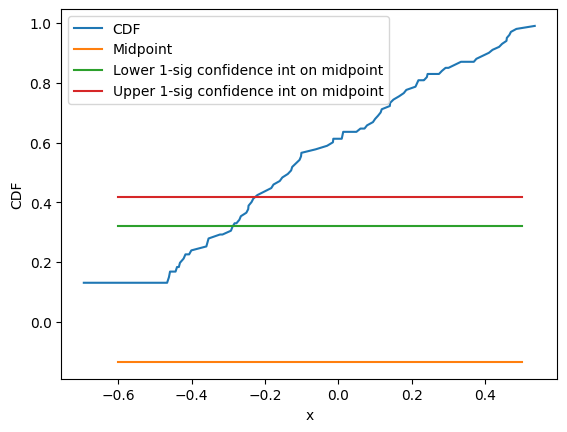

In [82]:
plt.plot(cdf['km']['x'],cdf['km']['surv'],label='CDF')
plt.plot([-0.6,0.5],[cdf['midpoint'],cdf['midpoint']],label='Midpoint')
plt.plot([-0.6,0.5],[cdf['l68'],cdf['l68']],label='Lower 1-sig confidence int on midpoint')
plt.plot([-0.6,0.5],[cdf['h68'],cdf['h68']],label='Upper 1-sig confidence int on midpoint')
plt.xlabel('x')
plt.ylabel('CDF')
plt.legend()


<Axes: xlabel='timeline'>

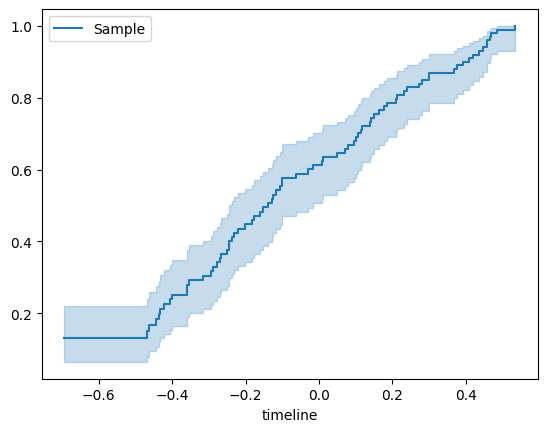

In [83]:
#This will do the same thing using the Kaplan Meier code in lifelines, looks the same but has nice error ranges. I'd do this one.
kmf = KaplanMeierFitter()
kmf.fit_left_censoring(yres,~lims) #Lims=True for upper limits, but this function assumes you pass a list of True for detections.
kmf.plot_cumulative_density(label='Sample') #will plot the CDF


## Comparing Distributions

If you have all measurements, you can do a


*   KS2Sample Test (scipy.ks2samp)
*   Anderson-Darling Test (scipy.anderson_ksamp)

These return a probability of the null hypothesis (pvalue), that the samples are drawn from the SAME distribution - so low pvalues mean they are likely different ($p<0.05$ is a common threshold)

Statisticians prefer Anderson-Darling because it is more sensititve to the extremes of the distribution.

This doesn't work for datasets with upperlimits (left or right censorered), but we can compare the CDFs, which can return similar statistics.

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.65 <0.005     12.15

0.00022019529671574943
13.650392413282209


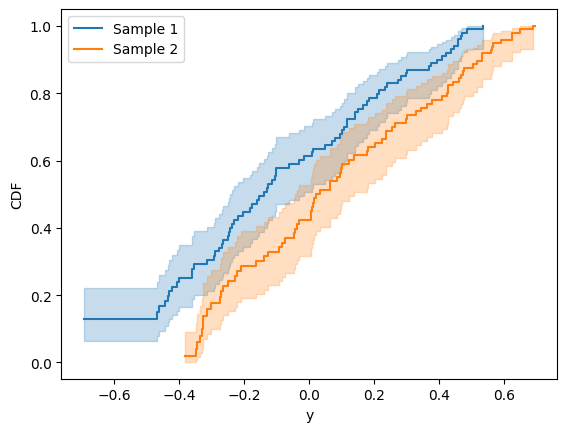

In [87]:
#let's make a second sample with a different distribution and compare them
y2 = 5.1 + (3.1 * x) + np.random.uniform(size=100) #Just a line with error of size 0-1
yres2= y2-p(x)

kmf.fit_left_censoring(yres,~lims) #Lims=True for upper limits, but this function assumes you pass a list of True for detections.
kmf.plot_cumulative_density(label='Sample 1') #will plot the CDF

kmf.fit_left_censoring(yres2, ~lims)
kmf.plot_cumulative_density(label='Sample 2') #will plot the CDF

plt.xlabel('y')
plt.ylabel('CDF')

results = logrank_test(-yres, -yres2, event_observed_A=~lims, event_observed_B=~lims)
results.print_summary()
print(results.p_value)

print(results.test_statistic)

## Fitting a Line with Upper Limits

Obviously our random data has some correlations. So we can try to deal with that too.

### Akritas-Theil-Sen estimator

The Akritas-Theil-Sen (ATS) estimator (Akritas et al. 1995) is a method which can be used to fit a line to data in the presence of upper limits.

More should be written here about how this works, but first think about the problem - usually line fits is done by minimising some kind of sum of the distance from the points to the best fit line. With upper limits you don't know the actual distance, only the minimum/maximum it could be (for upper limits below/above the line of best fit). So this technique accounts for that by minimising a median value of residuals using other techniques for calculating medians in the presence of upper limits (I think that's what I understand anyway).

In [88]:
#This command (a function from survival.py) runs cenken from R (Akritas-Theil-Sen estimator) to determine correlation
# strength and line fit parameters in the presence of upper limits

out = ats_fit(x,y,lims,fmt='(I4, 2F10.3)')
out

#The return will be the slope and intercept of the best fit line,
#It also returns tau (Kendall's tau; or Kendall's rank correlation coefficient)
#and p-value (probability of no correlation) for the regression.
#Small p-values and tau far from 0 suggest good correlation.
#And it will return estimates of the sigma (variance) both above and below the line


slope 
[1] 2.961367

intercept 
[1] 5.368462

tau 
[1] 0.5806061

p 
[1] 0



{'slope': array([2.96136709]),
 'intercept': array([5.37368908]),
 'tau': array([0.58060606]),
 'p': array([0.]),
 'sigma_up': array([0.33815503]),
 'sigma_down': array([0.37052199])}

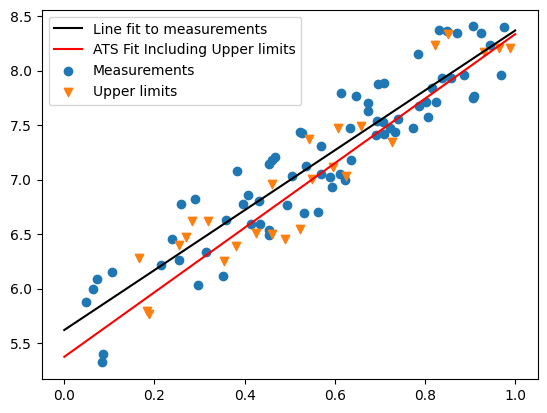

In [92]:
#Now lets plot the line over our fake data

xplot2=np.arange(0,1.1,0.1) #Makes array from 0-1, step size 0.1
yplot2=out['slope'][0]*xplot2+out['intercept'][0] #Makes line
plt.plot(xplot,yplot,'k',label='Line fit to measurements')
plt.plot(xplot2,yplot2,'r',label='ATS Fit Including Upper limits')
plt.plot

#plt.xlim(0,1)
plt.scatter(x[~lims],y[~lims],label='Measurements') #Scatter plot of the actually measurement (NOT lims is ~lims)
plt.scatter(x[lims], y[lims], marker='v',label='Upper limits') #Scatter plot of the upper limits (lims=TRUE entries)
plt.legend()